<a href="https://colab.research.google.com/github/37stu37/GNS_GAN/blob/master/ctganCity.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Import



In [45]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [46]:
%%time
%%capture
!apt update
!apt upgrade
!apt install gdal-bin python-gdal python3-gdal
# Install rtree - Geopandas requirment
!apt install python3-rtree
# Install Geopandas
!pip install git+git://github.com/geopandas/geopandas.git
# Install descartes - Geopandas requirment
!pip install descartes
!pip install memory_profiler

#panda profiling
!pip install -U pandas-profiling[notebook]
!jupyter nbextension enable --py widgetsnbextension

#contextily
!pip3 install contextily

CPU times: user 135 ms, sys: 93.5 ms, total: 228 ms
Wall time: 33.5 s


# Data

In [0]:
# import pandas as pd
from pathlib import Path
import pandas as pd
from shapely.geometry import box
import geopandas as gpd
import matplotlib.pyplot as plt

In [0]:
outputDir = Path('/content/drive/My Drive/Colab Notebooks/02_output/ctgan')
pathShapefile = Path('/content/drive/My Drive/Colab Notebooks/01_githubRepo/FFE/data/shapefile')

In [0]:
edges = pd.read_parquet(outputDir / 'smallMonteCarlo2500runs.parquet')
buildings = gpd.read_file(pathShapefile, bbox=box(1748570, 5425500, 1749500, 5427600))

In [50]:
buildings.columns

Index(['TARGET_FID', 'suburb_loc', 'Combustibl', 'SHAPE_Leng', 'SHAPE_Area',
       'AU2013Num', 'IgnProb_bl', 'RandProb', 'geometry'],
      dtype='object')

In [0]:
edges.drop_duplicates(subset=['source', 'target'], inplace=True)
# edges.drop(['IgnProb_bl', 'scenario','pid'], axis=1, inplace=True)
eBuildings = pd.merge(buildings, edges, how='right', 
                      left_on='TARGET_FID', right_on='source')

In [0]:
eBuildings = eBuildings[['SHAPE_Leng', 'SHAPE_Area',
                         'geometry', 'source', 'target',
                         'distance', 'bearing']]

In [0]:
eBuildings = pd.merge(eBuildings, buildings[['geometry', 'TARGET_FID']], how='left', 
                      left_on='target', right_on='TARGET_FID')
eBuildings.rename(columns={'geometry_x': 'geometry'}, inplace=True)
eBuildings.drop(['geometry_y','TARGET_FID'], axis=1, inplace=True)

In [0]:
eBuildings["x"] = eBuildings.centroid.x
eBuildings["y"] = eBuildings.centroid.y

In [67]:
eBuildings.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
Int64Index: 1606 entries, 0 to 47032
Data columns (total 9 columns):
 #   Column      Non-Null Count  Dtype   
---  ------      --------------  -----   
 0   SHAPE_Leng  1606 non-null   float64 
 1   SHAPE_Area  1606 non-null   float64 
 2   geometry    1606 non-null   geometry
 3   source      1606 non-null   int64   
 4   target      1606 non-null   int64   
 5   distance    1606 non-null   float64 
 6   bearing     1606 non-null   float64 
 7   x           1606 non-null   float64 
 8   y           1606 non-null   float64 
dtypes: float64(6), geometry(1), int64(2)
memory usage: 125.5 KB


#**Data pre-processing**



In [0]:
eBuildingsNoDuplicate = eBuildings.drop_duplicates(subset=['source'], keep='first')

In [71]:
eBuildingsNoDuplicate.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
Int64Index: 1606 entries, 0 to 47032
Data columns (total 9 columns):
 #   Column      Non-Null Count  Dtype   
---  ------      --------------  -----   
 0   SHAPE_Leng  1606 non-null   float64 
 1   SHAPE_Area  1606 non-null   float64 
 2   geometry    1606 non-null   geometry
 3   source      1606 non-null   int64   
 4   target      1606 non-null   int64   
 5   distance    1606 non-null   float64 
 6   bearing     1606 non-null   float64 
 7   x           1606 non-null   float64 
 8   y           1606 non-null   float64 
dtypes: float64(6), geometry(1), int64(2)
memory usage: 125.5 KB


In [0]:
trainingSample = eBuildingsNoDuplicate.sample(n=500)

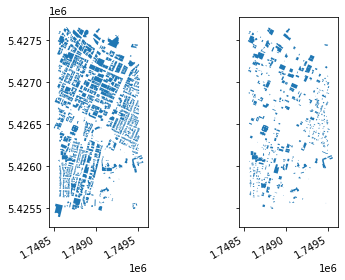

In [83]:
fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, sharex=True, sharey=True)
eBuildingsNoDuplicate.plot(ax=ax1)
trainingSample.plot(ax=ax2)
fig.autofmt_xdate()
plt.tight_layout()
plt.show()

In [0]:
trainingSampleGeometry = trainingSample.geometry
trainingSample.drop(['geometry'], axis=1, inplace=True)
discrete_columns = ['source', 'target']

In [85]:
trainingSample.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
Int64Index: 500 entries, 8903 to 225
Data columns (total 8 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   SHAPE_Leng  500 non-null    float64
 1   SHAPE_Area  500 non-null    float64
 2   source      500 non-null    int64  
 3   target      500 non-null    int64  
 4   distance    500 non-null    float64
 5   bearing     500 non-null    float64
 6   x           500 non-null    float64
 7   y           500 non-null    float64
dtypes: float64(6), int64(2)
memory usage: 35.2 KB


#**CTGAN**

In [0]:
%%capture
!pip install ctgan 

In [0]:
%%time
from ctgan import CTGANSynthesizer

e = 540
ctgan = CTGANSynthesizer()
ctgan.fit(trainingSample, discrete_columns, epochs=e)

##**Generate synthetic data**

In [0]:
!pip show pandas
!pip install pandas==1.0.4

In [0]:
samples = ctgan.sample(1600)

In [99]:
from shapely.geometry import Point, Polygon
geometry = [Point(xy) for xy in zip(samples.x, samples.y)]
samples['geometry'] = geometry
# samples.drop(['x','y'], axis = 1, inplace=True)
crs = {'init': 'epsg:2193'}
sample_locs = gpd.GeoDataFrame(samples, crs=crs, geometry=geometry)

/usr/local/lib/python3.6/dist-packages/pyproj/crs/crs.py:53: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  return _prepare_from_string(" ".join(pjargs))


In [0]:
e

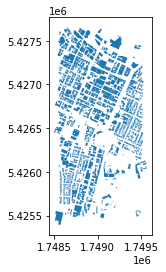

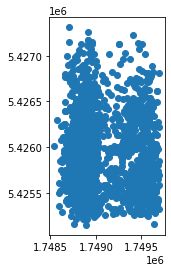

In [101]:
eBuildingsNoDuplicate.plot()
sample_locs.plot()